In [1]:
# 添加搜索路径
import sys
sys.path.insert(0, "/root/mounted/projects/qpair/")

In [2]:
import os
import pickle
import numpy as np
import time, datetime
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.regularizers import l2
from keras.callbacks import Callback, ModelCheckpoint, TensorBoard, LambdaCallback

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
from config import * # 加载全局配置
from baselines import MODEL_WEM # 加载模型
from baselines import MODEL_WEM_ATTENTION

MODEL_WEIGHTS_FILE = './keras_saved_models/baseline_model_wem.h5'

# KN_PAIRS_SAMPLED_PATH = '/root/mounted/datasets/make_data/intermediate/'
KN_PAIRS_SAMPLED_PATH = '/root/mounted/datasets/data_0521/intermediate/'
KN_PAIRS_SAMPLED_WIDS_CIDS_TRAIN_PKL = os.path.join(KN_PAIRS_SAMPLED_PATH, 'kn_train_test_pairs_sampled_wids_cids_train.pkl')
KN_PAIRS_SAMPLED_WIDS_CIDS_TEST_PKL = os.path.join(KN_PAIRS_SAMPLED_PATH, 'kn_train_test_pairs_sampled_wids_cids_test.pkl')

VALIDATION_SPLIT = 0.1
RNG_SEED = 13371447
NB_EPOCHS = 50
BATCH_SIZE = 1024

In [4]:
# 加载模型
model = MODEL_WEM()
# model = MODEL_WEM_ATTENTION()

In [5]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 39)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 39)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 39, 300)      6267600     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 39, 300)      6267600     input_2[0][0]                    
__________________________________________________________________________________________________
time_distr

In [6]:
# 加载数据集，并切分成train 和 validation
with open(KN_PAIRS_SAMPLED_WIDS_CIDS_TRAIN_PKL, 'rb') as f:
    kn_train_wids_cids_padded = pickle.load(f)

kn_train_wids_cids_padded.head()

,label,qid1,qid2,q1_q2_intersect,words1,chars1,words2,chars2
0,1,Q173098,Q208402,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,1,Q717916,Q208402,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,1,Q525051,Q208402,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,1,Q526868,Q208402,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,1,Q659349,Q208402,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [7]:
with open(KN_PAIRS_SAMPLED_WIDS_CIDS_TEST_PKL, 'rb') as f:
    kn_test_wids_cids_padded = pickle.load(f)

kn_test_wids_cids_padded

,label,qid1,qid2,q1_q2_intersect,words1,chars1,words2,chars2
0,1,Q151557,Q293789,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,0,Q363892,Q293789,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,1,Q628193,Q293789,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,0,Q079906,Q293789,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,0,Q076694,Q293789,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5,0,Q182681,Q293789,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
6,0,Q078250,Q293789,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
7,1,Q312362,Q489267,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
8,1,Q183757,Q521124,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
9,1,Q284611,Q521124,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [8]:
# 暂时的
# kn_train_wids_cids_padded = pd.concat([kn_train_wids_cids_padded, kn_test_wids_cids_padded], ignore_index=True)

In [9]:
q1_inputs = kn_train_wids_cids_padded['words1'].values
q2_inputs = kn_train_wids_cids_padded['words2'].values
inputs = np.stack((q1_inputs, q2_inputs), axis=1)
labels = kn_train_wids_cids_padded['label']
inputs_train, inputs_val, labels_train, labels_val = train_test_split(inputs, labels, test_size=VALIDATION_SPLIT, random_state=RNG_SEED)
q1_train = np.array(list(inputs_train[:,0]))
q2_train = np.array(list(inputs_train[:,1]))
q1_val = np.array(list(inputs_val[:,0]))
q2_val = np.array(list(inputs_val[:,1]))

In [10]:
inputs_train.shape, inputs_val.shape

((187220, 2), (20803, 2))

In [11]:
np.array(list(q1_train)).shape

(187220, 39)

In [12]:
q1_test_inputs = np.array(list(kn_test_wids_cids_padded['words1'].values))
q2_test_inputs = np.array(list(kn_test_wids_cids_padded['words2'].values))
labels_test = kn_test_wids_cids_padded['label']

In [13]:
test_score = []
lambda_cb = LambdaCallback(on_epoch_end= lambda epock, logs: test_score.append(model.evaluate([q1_test_inputs, q2_test_inputs], labels_test, verbose=0)))

print("Starting training at", datetime.datetime.now())
t0 = time.time()
callbacks = [ModelCheckpoint(MODEL_WEIGHTS_FILE, monitor='val_acc', save_best_only=True),TensorBoard(log_dir='/root/mounted/tensorboard/log'), lambda_cb]
history = model.fit([q1_train, q2_train],
                    labels_train,
                    epochs=NB_EPOCHS,
#                     validation_data = ([q1_test_inputs, q2_test_inputs], labels_test),
                    validation_data = ([q1_val, q2_val], labels_val),
                    verbose=2,
                    batch_size=BATCH_SIZE,
                    callbacks=callbacks)
t1 = time.time()
print("Training ended at", datetime.datetime.now())
print("Minutes elapsed: %f" % ((t1 - t0) / 60.))

Starting training at 2018-05-23 07:56:43.541234
Train on 187220 samples, validate on 20803 samples
Epoch 1/50
 - 4s - loss: 0.6529 - acc: 0.6398 - val_loss: 0.4284 - val_acc: 0.8101
Epoch 2/50
 - 4s - loss: 0.4475 - acc: 0.8030 - val_loss: 0.3559 - val_acc: 0.8382
Epoch 3/50
 - 4s - loss: 0.3854 - acc: 0.8367 - val_loss: 0.3183 - val_acc: 0.8632
Epoch 4/50
 - 4s - loss: 0.3534 - acc: 0.8504 - val_loss: 0.2979 - val_acc: 0.8694
Epoch 5/50
 - 4s - loss: 0.3352 - acc: 0.8579 - val_loss: 0.2841 - val_acc: 0.8770
Epoch 6/50
 - 4s - loss: 0.3212 - acc: 0.8630 - val_loss: 0.2757 - val_acc: 0.8822
Epoch 7/50
 - 4s - loss: 0.3105 - acc: 0.8675 - val_loss: 0.2721 - val_acc: 0.8783
Epoch 8/50
 - 4s - loss: 0.3028 - acc: 0.8707 - val_loss: 0.2642 - val_acc: 0.8851
Epoch 9/50
 - 4s - loss: 0.2950 - acc: 0.8740 - val_loss: 0.2637 - val_acc: 0.8897
Epoch 10/50
 - 4s - loss: 0.2893 - acc: 0.8764 - val_loss: 0.2506 - val_acc: 0.8917
Epoch 11/50
 - 4s - loss: 0.2820 - acc: 0.8786 - val_loss: 0.2589 - va

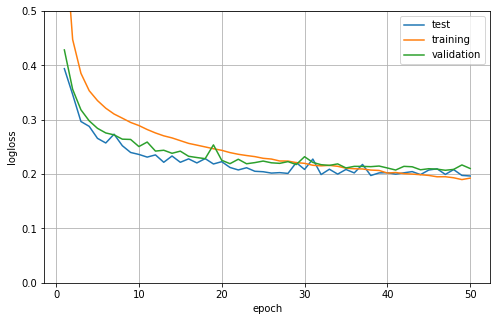

In [38]:
acc = pd.DataFrame({'epoch': [ i + 1 for i in history.epoch ],
                    'training': history.history['loss'],
                    'validation': history.history['val_loss'],
                    'test': np.array(test_score)[:,0]})
ax = acc.iloc[:,:].plot(x='epoch', figsize=(8,5), grid=True)
ax.set_ylabel("logloss")
ax.set_ylim([0,0.5]);

In [23]:
np.array(test_score)[:,0]

array([0.39388673, 0.34646452, 0.29669099, 0.28776851, 0.26570072,
       0.25722937, 0.27335616, 0.2521924 , 0.23974526, 0.2361416 ,
       0.23122074, 0.2352965 , 0.22170622, 0.2332334 , 0.22169597,
       0.22797988, 0.22052116, 0.22843548, 0.2185774 , 0.22281674,
       0.21214494, 0.20760127, 0.21166286, 0.20516436, 0.20431237,
       0.20182679, 0.20265642, 0.20125396, 0.22114579, 0.20855935,
       0.22760256, 0.19914985, 0.20892044, 0.19992867, 0.20849403,
       0.20213945, 0.21769456, 0.19736333, 0.20214596, 0.20254789,
       0.19986284, 0.20234879, 0.20454886, 0.19900876, 0.20744307,
       0.20973712, 0.19937928, 0.20827493, 0.19754153, 0.19650315])

In [19]:
len(history.history['val_loss'])

50

In [ ]:
history.history

In [ ]:
TEST_WIDS_CIDS_PADDED_PKL = os.path.join(INTERMEDIATE_DATA_PATH, 'test_clean_wids_cids_padded.pkl')
with open(TEST_WIDS_CIDS_PADDED_PKL, 'rb') as f:
    test_wids_cids_padded = pickle.load(f)
    
test_wids_cids_padded.head()

In [ ]:
q1_test_inputs = np.array(list(test_wids_cids_padded['words1'].values))
q2_test_inputs = np.array(list(test_wids_cids_padded['words2'].values))
test_labels = test_wids_cids_padded['label']
q1_test_inputs.shape

In [ ]:
# 直接用最后一个epoch的模型
test_pred1 = model.predict([q1_test_inputs, q2_test_inputs], batch_size=BATCH_SIZE)
test_pred1 = test_pred1.squeeze()
test_pred1

In [ ]:
max(test_pred1), sum(test_pred1), sum(test_pred1) / 24090

In [ ]:
test_pred1_df = pd.DataFrame({'y_pre':test_pred1})
test_pred1_df

In [ ]:
TEST_PRED_1 = './predicts/test_pred1.csv'
test_pred1_df.to_csv(TEST_PRED_1, index=False)

In [ ]:
model.load_weights(MODEL_WEIGHTS_FILE)
test_pred2 = model.predict([q1_test_inputs, q2_test_inputs], batch_size=BATCH_SIZE)
test_pred2 = test_pred2.squeeze()
test_pred2

In [ ]:
diff = test_pred2 - test_pred1
max(diff), sum(diff), sum(diff)/24090

In [ ]:
score = model.evaluate([q1_test_inputs, q2_test_inputs], test_labels)
score